From one callsign, identify all the corresponding ATCO communications. 
idea:
 - Take a flight from A to B
 - identify which area / frequency they are contacting
 - download data from this frequency
 - Match the communications that were made with this flight

In [17]:
from typing import List
import re
from collections import Counter
import random

from datetime import datetime, timezone

from traffic.core import Traffic
from utils.cs_matching import build_timestamp_range, callsign_to_words
from utils.liveatc_utils import extract_timestamp_from_path

from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipyleaflet import Marker

adsb_path = "adsb/EPWA-epwa_app-Jun-27-2025-1830Z.parquet"
transcript_path = "transcripts/EPWA-epwa_app-Jun-27-2025-1830Z.txt"

adsb = Traffic.from_file(adsb_path)
timestamp_range = build_timestamp_range(adsb_path)
start_timestamp = extract_timestamp_from_path(transcript_path)

tokenizer = AutoTokenizer.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
model_ner = AutoModelForTokenClassification.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
nlp = pipeline('ner', model=model_ner, tokenizer=tokenizer, aggregation_strategy="simple")

model_embedding = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

Device set to use cpu


In [2]:
# Merge entities if two consecutive callsigns.

def merge_callsign_entities(entities):
    merged = []
    i = 0
    while i < len(entities):
        entity = entities[i]

        # If current entity is not a callsign, just append
        if entity["entity_group"] != "callsign":
            merged.append(entity)
            i += 1
            continue

        # Start merging if it's a callsign
        merged_word = entity["word"]
        start_pos = entity["start"]
        end_pos = entity["end"]
        score_sum = entity["score"]
        count = 1

        # Look ahead for consecutive callsigns
        while i + 1 < len(entities) and entities[i + 1]["entity_group"] == "callsign":
            next_entity = entities[i + 1]
            merged_word += " " + next_entity["word"]
            end_pos = next_entity["end"]
            score_sum += next_entity["score"]
            count += 1
            i += 1

        # Append merged callsign entity
        merged.append({
            "entity_group": "callsign",
            "word": merged_word,
            "start": start_pos,
            "end": end_pos,
            "score": score_sum / count  # average score
        })
        i += 1

    return merged

In [3]:
# Add a selection based on the time matching in flight (for en route)
# Doesn't work here as we have ground communication and ground adsb is not always reliable. 

from collections import defaultdict

callsign_communications = defaultdict(list)

with open(transcript_path) as f:
    lines = [line.strip() for line in f if line.strip()]

match_threshold = 0.6
active_cs = {cs: callsign_to_words(cs) for cs in adsb.callsigns}
context_cs = list(active_cs.values())
context_cs_embeddings = model_embedding.encode(context_cs, convert_to_tensor=True)
    
for i, line in enumerate(lines):
    regex = re.match(r"\[(\d{2}:\d{2}:\d{2})\]\s*(.*)", line)
    timestamp = regex.group(1)
    sentence = regex.group(2)
    
    atco2_res = nlp(sentence)
    atco2_res = merge_callsign_entities(atco2_res)
    callsigns = [e for e in atco2_res if e['entity_group'] == 'callsign']
    
    best_match = None
    best_score = -1
    best_ner_callsign = None

    for cs in callsigns:
        cs_word = cs["word"]
        cs_embedding = model_embedding.encode(cs_word, convert_to_tensor=True)
        match_scores = util.cos_sim(cs_embedding, context_cs_embeddings)[0]

        top_index = match_scores.argmax()
        top_score = float(match_scores[top_index])
        top_context_cs = list(active_cs.keys())[top_index]

        if top_score > best_score and top_score > match_threshold:
            best_score = top_score
            best_match = top_context_cs
            best_ner_callsign = cs_word

    if best_match:
        callsign_communications[best_match].append({
            "timestamp": timestamp,
            "sentence": sentence,
            "detected": best_ner_callsign,
            "score": round(best_score, 2)
        })
        print(f"[{i}]: {timestamp} {sentence} -> [{best_match}, {best_score:.2f}] (detected as: {best_ner_callsign})")
    else:
        print(f"[{i}]: {timestamp} {sentence} -> No good match found")

[0]: 18:30:23 air france two nine uniform kilo no speed restrictions contact tower one one eight decimal three zero five good day -> [AFR29UK, 1.00] (detected as: air france two nine uniform kilo)
[1]: 18:30:24 no speed restriction -> No good match found
[2]: 18:30:26 tower one one eight three zero -> [LOT6340, 0.67] (detected as: tower one one eight three zero)
[3]: 18:30:33 quality two india xray approach -> [TAY2IX, 1.00] (detected as: quality two india xray)
[4]: 18:30:34 go ahead twin air xray -> No good match found
[5]: 18:30:39 hello start again turn right heading two four zero descend altitude three thousand feet -> No good match found
[6]: 18:30:42 right heading two four zero descend altitude three thousand feet qality two eight xray -> No good match found
[7]: 18:30:58 quality two india xray reduce speed two one zero knots -> [TAY2IX, 1.00] (detected as: quality two india xray)
[8]: 18:31:00 reducing speed two one zero knots between the xray -> No good match found
[9]: 18:31:

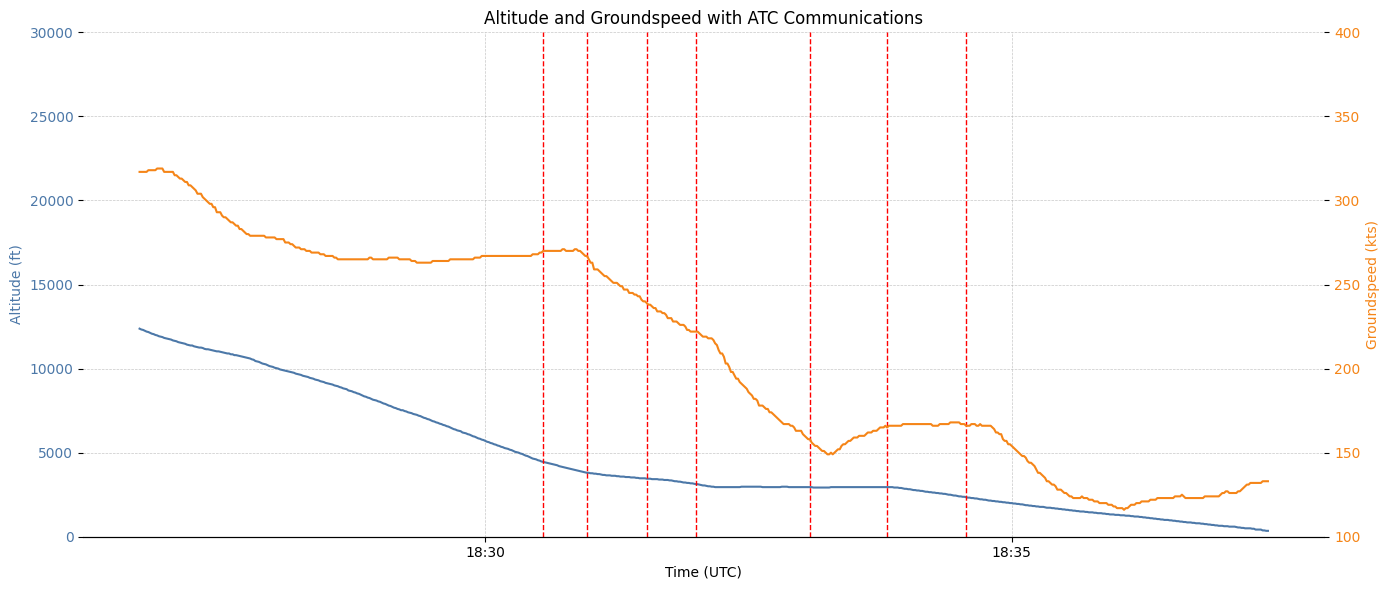

In [18]:
# cs = random.sample(list(adsb.callsigns), 1)[0]
cs = "TAY2IX"
date = adsb[cs].start.strftime("%Y-%m-%d")
timestamps = [
    datetime.strptime(f"{date} {entry['timestamp']}", "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    for entry in callsign_communications[cs]
]
flight = adsb[cs]


df = flight.data.copy()
fig, ax1 = plt.subplots(figsize=(14, 6))

# Altitude plot
ax1.plot(df["timestamp"], df["altitude"], color="#4c78a8", label="Altitude (ft)")
ax1.set_ylabel("Altitude (ft)", color="#4c78a8")
ax1.tick_params(axis='y', labelcolor="#4c78a8")
ax1.set_ylim(0, 30000)

# Groundspeed plot on second y-axis
ax2 = ax1.twinx()
ax2.plot(df["timestamp"], df["groundspeed"], color="#f58518", label="Groundspeed (kts)")
ax2.set_ylabel("Groundspeed (kts)", color="#f58518")
ax2.tick_params(axis='y', labelcolor="#f58518")
ax2.set_ylim(100, 400)

# Add communication markers as vertical lines
for ts in timestamps:
    ax1.axvline(ts, color="red", linestyle="--", linewidth=1)

# Format x-axis with time
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel("Time (UTC)")
plt.title("Altitude and Groundspeed with ATC Communications")

ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [19]:
callsign_communications[cs]

[{'timestamp': '18:30:33',
  'sentence': 'quality two india xray approach',
  'detected': 'quality two india xray',
  'score': 1.0},
 {'timestamp': '18:30:58',
  'sentence': 'quality two india xray reduce speed two one zero knots',
  'detected': 'quality two india xray',
  'score': 1.0},
 {'timestamp': '18:31:32',
  'sentence': 'quality two india xray reduce speed one nine zero knots',
  'detected': 'quality two india xray',
  'score': 1.0},
 {'timestamp': '18:32:00',
  'sentence': 'quality two india xray turn right heading three zero zero cleared ils zulu approach runway three three',
  'detected': 'quality two india xray',
  'score': 1.0},
 {'timestamp': '18:33:05',
  'sentence': 'turkish two india xray please maintain speed one eight zero knots or greater until six miles dme',
  'detected': 'turkish two india xray',
  'score': 0.73},
 {'timestamp': '18:33:49',
  'sentence': 'quality two india xray roger',
  'detected': 'quality two india xray',
  'score': 1.0},
 {'timestamp': '18:34

In [20]:
m = flight.map_leaflet()

for ts in timestamps:
    if flight.at(ts) is not None:
        marker = Marker(location=(flight.at(ts).latitude, flight.at(ts).longitude))
        m.add(marker)

m

Map(center=[52.09932031218837, 21.233513714469634], controls=(ZoomControl(options=['position', 'zoom_in_text',…